# Desafio Técnico – Ciência de Dados

Este notebook apresenta a integração, limpeza, análise exploratória e visualização
de logs de eventos de uma empresa fictícia, contemplando duas unidades empresariais
(Unidade A e Unidade B) ao longo do ano de 2024.

O objetivo é transformar dados brutos, distribuídos em diferentes formatos,
em informações úteis para análise e tomada de decisão.


In [96]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

In [97]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.listdir("/content/drive/MyDrive/Desafio_Ciencia_Dados/")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['logs_descricoes.db',
 'logs2024.csv',
 'logs_24.txt',
 'logs_origens.db',
 'logs_eventos_base.db',
 'logs_classificacoes.db',
 '2024logs.json']

In [98]:
def limpar_dados(df):
    df = df.copy()

    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp"])

    df["descricao"] = df["descricao"].fillna("SEM_DESCRICAO")
    df["tempo_processamento"] = df["tempo_processamento"].clip(lower=0)

    return df


### Limpeza e Padronização dos Dados

Foi criada uma função dedicada para realizar a limpeza e padronização
dos dados, garantindo reprodutibilidade e facilitando a reutilização do
processo em análises futuras.


## Fontes de Dados

Os dados analisados estão distribuídos em múltiplos formatos, incluindo arquivos CSV,
TXT, JSON e bancos de dados relacionais (SQLite). Cada fonte representa uma parcela
dos eventos operacionais da empresa ao longo de 2024.

O desafio consiste em integrar essas diferentes fontes em um dataset único,
padronizado e pronto para análise.


In [99]:
base_path = "/content/drive/MyDrive/Desafio_Ciencia_Dados/"


In [100]:
df_csv = pd.read_csv(
    base_path + "logs2024.csv",
    encoding="latin1",
    sep=";"
)

df_csv.head()




,id_evento,unidade_origem,data_evento,hora_evento,categoria,subcategoria,tempo_proc,descricao
0,1,B,2024-01-01,00:01:10.432434,Administrativo,Configuração,1.10,SEM_DESCRICAO
1,2,B,2024-01-01,00:01:12.674048,Operacional,Execução,3.64,SEM_DESCRICAO
2,3,B,2024-01-01,00:02:44.893128,Administrativo,Rejeição,2.95,SEM_DESCRICAO
3,4,B,2024-01-01,00:02:55.082969,Administrativo,Rejeição,3.89,Rejeição registrada no sistema
4,5,A,2024-01-01,00:03:39.359099,Administrativo,Aprovação,1.59,SEM_DESCRICAO


### Tratamento de separador e codificação

O arquivo CSV utiliza o caractere `;` como separador e codificação `latin1`,
padrões comuns em sistemas legados. A leitura foi ajustada para garantir
a correta separação das colunas e preservação de caracteres acentuados.


In [101]:
df_csv.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130530 entries, 0 to 130529
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_evento       130530 non-null  int64  
 1   unidade_origem  130530 non-null  object 
 2   data_evento     130530 non-null  object 
 3   hora_evento     130530 non-null  object 
 4   categoria       130530 non-null  object 
 5   subcategoria    130530 non-null  object 
 6   tempo_proc      130530 non-null  float64
 7   descricao       130530 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 8.0+ MB


In [102]:
df_csv["timestamp"] = pd.to_datetime(
    df_csv["data_evento"] + " " + df_csv["hora_evento"],
    errors="coerce"
)

df_csv[["data_evento", "hora_evento", "timestamp"]].head()


,data_evento,hora_evento,timestamp
0,2024-01-01,00:01:10.432434,2024-01-01 00:01:10.432434
1,2024-01-01,00:01:12.674048,2024-01-01 00:01:12.674048
2,2024-01-01,00:02:44.893128,2024-01-01 00:02:44.893128
3,2024-01-01,00:02:55.082969,2024-01-01 00:02:55.082969
4,2024-01-01,00:03:39.359099,2024-01-01 00:03:39.359099


### Construção da variável temporal

As colunas de data e hora foram combinadas para criar uma variável temporal única
(`timestamp`), permitindo análises temporais com precisão de microssegundos.


In [103]:
df = df_csv.rename(columns={
    "id_evento": "id",
    "unidade_origem": "unidade",
    "tempo_proc": "tempo_processamento"
})


In [104]:
df = df.drop(columns=["data_evento", "hora_evento"])
df.head()


,id,unidade,categoria,subcategoria,tempo_processamento,descricao,timestamp
0,1,B,Administrativo,Configuração,1.10,SEM_DESCRICAO,2024-01-01 00:01:10.432434
1,2,B,Operacional,Execução,3.64,SEM_DESCRICAO,2024-01-01 00:01:12.674048
2,3,B,Administrativo,Rejeição,2.95,SEM_DESCRICAO,2024-01-01 00:02:44.893128
3,4,B,Administrativo,Rejeição,3.89,Rejeição registrada no sistema,2024-01-01 00:02:55.082969
4,5,A,Administrativo,Aprovação,1.59,SEM_DESCRICAO,2024-01-01 00:03:39.359099


### Padronização de colunas

Os nomes das colunas foram padronizados para facilitar a leitura,
manutenção do código e integração com outras fontes de dados.


## Estrutura do Dataset

O dataset principal é composto por eventos (tabela fato), contendo informações
temporais, categóricas e operacionais.

As demais fontes (bancos relacionais e arquivos auxiliares) serão utilizadas
como tabelas de apoio para enriquecimento e validação das informações.


In [105]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130530 entries, 0 to 130529
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   id                   130530 non-null  int64         
 1   unidade              130530 non-null  object        
 2   categoria            130530 non-null  object        
 3   subcategoria         130530 non-null  object        
 4   tempo_processamento  130530 non-null  float64       
 5   descricao            130530 non-null  object        
 6   timestamp            130529 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 7.0+ MB


In [106]:
df[df["timestamp"].isna()]


,id,unidade,categoria,subcategoria,tempo_processamento,descricao,timestamp
95280,95281,A,Operacional,Execução,2.6,Execução de tarefa concluída,NaT


In [107]:
df = df.dropna(subset=["timestamp"])
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 130529 entries, 0 to 130529
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   id                   130529 non-null  int64         
 1   unidade              130529 non-null  object        
 2   categoria            130529 non-null  object        
 3   subcategoria         130529 non-null  object        
 4   tempo_processamento  130529 non-null  float64       
 5   descricao            130529 non-null  object        
 6   timestamp            130529 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 8.0+ MB


As colunas originais de data e hora são removidas caso ainda existam,
pois a análise temporal passa a utilizar exclusivamente a coluna
`timestamp`.


In [108]:
df = df.drop(columns=["data_evento", "hora_evento"], errors="ignore")



### Limpeza final do dataset

Após a criação da variável temporal unificada (`timestamp`), as colunas originais
de data e hora foram removidas por se tornarem redundantes, mantendo o dataset
mais enxuto e consistente para análise.


In [109]:
df.describe(include="all")


,id,unidade,categoria,subcategoria,tempo_processamento,descricao,timestamp
count,130529.000000,130529,130529,130529,130529.000000,130529,130529
unique,NaN,3,3,11,NaN,31,NaN
top,NaN,A,Operacional,Emissão,NaN,SEM_DESCRICAO,NaN
freq,NaN,74716,79454,26124,NaN,108125,NaN
mean,65265.270047,NaN,NaN,NaN,2.642268,NaN,2024-01-22 21:34:26.345057024
min,1.000000,NaN,NaN,NaN,0.100000,NaN,2024-01-01 00:01:10.432434
25%,32633.000000,NaN,NaN,NaN,1.600000,NaN,2024-01-11 15:06:16.544494080
50%,65265.000000,NaN,NaN,NaN,2.250000,NaN,2024-01-23 02:04:29.649675008
75%,97898.000000,NaN,NaN,NaN,3.160000,NaN,2024-02-02 16:03:06.651521024
max,130530.000000,NaN,NaN,NaN,18.370000,NaN,2024-02-14 07:20:14.952538


## Análise Exploratória

A base contém 130.529 eventos válidos, com informações categóricas, temporais
e métricas de tempo de processamento, permitindo análises comparativas e temporais.


### Principais observações iniciais

- A base contém 130.529 eventos válidos, com identificadores sequenciais.
- O tempo médio de processamento é de aproximadamente 2,6 segundos, com presença
  de eventos mais lentos que elevam a média.
- A maioria dos eventos pertence à categoria Operacional, indicando maior volume
  de atividades desse tipo.
- Mais de 80% dos registros possuem descrição ausente (`SEM_DESCRICAO`), evidenciando
  limitações na qualidade do log textual.
- O período analisado cobre aproximadamente 45 dias de eventos em 2024.


In [110]:
df["unidade"].value_counts()


,count
unidade,
A,74716
B,53251
ORIGEM_NAO_INFORMADA,2562


### Observação sobre unidade de origem

Além das Unidades A e B, foram identificados eventos com origem
`ORIGEM_NAO_INFORMADA`, representando aproximadamente 2% da base.
Esses registros foram mantidos e analisados separadamente, evitando
atribuições incorretas que poderiam distorcer comparações entre as unidades.


In [111]:
df_ab = df[df["unidade"].isin(["A", "B"])]



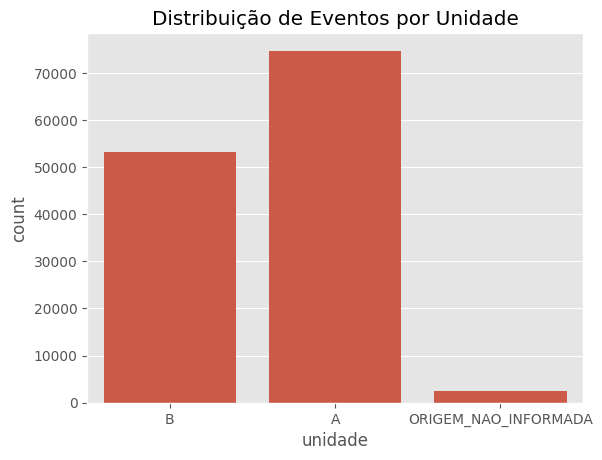

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x="unidade")
plt.title("Distribuição de Eventos por Unidade")
plt.show()


### Comparação entre Unidades

A análise evidencia diferenças no volume de eventos e no tempo médio de processamento
entre as Unidades A e B, sugerindo variações operacionais relevantes.Foi identificada uma parcela de eventos sem origem informada,
o que sugere oportunidades de melhoria no processo de logging
ou validação de dados na origem.


In [113]:
fig = px.box(
    df_ab,
    x="unidade",
    y="tempo_processamento",
    title="Tempo de Processamento por Unidade (A vs B)"
)
fig.show()


In [114]:
df_ab = df[df["unidade"].isin(["A", "B"])].copy()

df_ab["unidade"].value_counts()


,count
unidade,
A,74716
B,53251


In [115]:
df_ab.groupby("unidade")["tempo_processamento"].describe()


,count,mean,std,min,25%,50%,75%,max
unidade,,,,,,,,
A,74716.0,1.996597,1.013805,0.1,1.36,1.80,2.40,14.77
B,53251.0,3.549611,1.888409,0.1,2.33,3.11,4.12,18.37


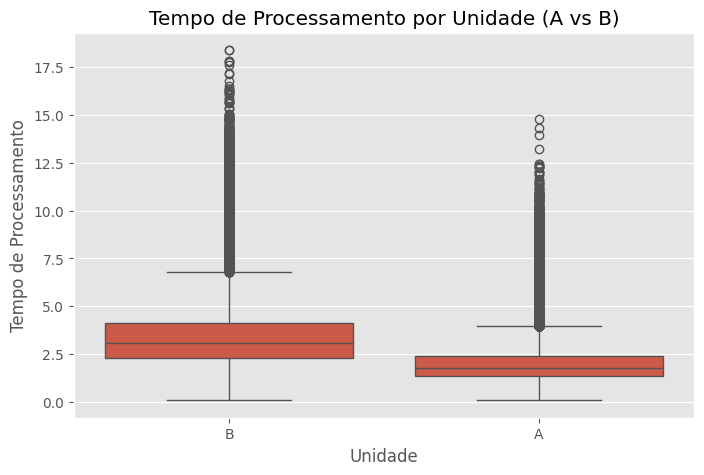

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(data=df_ab, x="unidade", y="tempo_processamento")
plt.title("Tempo de Processamento por Unidade (A vs B)")
plt.ylabel("Tempo de Processamento")
plt.xlabel("Unidade")
plt.show()


In [117]:
df_ab.groupby(["unidade", "categoria"])["tempo_processamento"].mean().reset_index()


,unidade,categoria,tempo_processamento
0,A,Administrativo,1.856871
1,A,Financeiro,3.464744
2,A,Operacional,1.858410
3,B,Administrativo,2.959945
4,B,Financeiro,5.999940
5,B,Operacional,3.556109


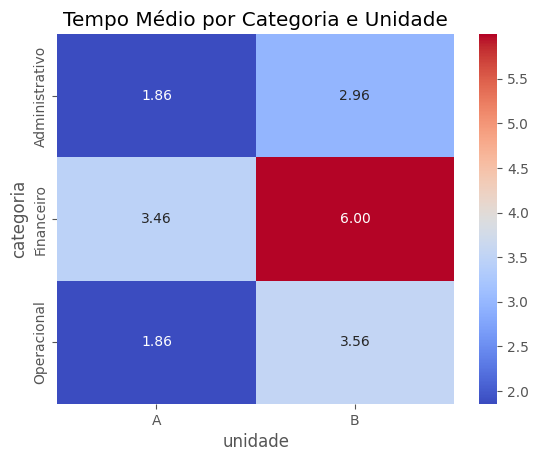

In [118]:
pivot = df_ab.pivot_table(
    values="tempo_processamento",
    index="categoria",
    columns="unidade",
    aggfunc="mean"
)

sns.heatmap(pivot, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Tempo Médio por Categoria e Unidade")
plt.show()


In [119]:
from scipy.stats import mannwhitneyu

tempo_a = df_ab[df_ab["unidade"] == "A"]["tempo_processamento"]
tempo_b = df_ab[df_ab["unidade"] == "B"]["tempo_processamento"]

stat, p_value = mannwhitneyu(tempo_a, tempo_b, alternative="two-sided")

p_value


np.float64(0.0)

In [120]:
print(f"p-value: {p_value:.6f}")


p-value: 0.000000


In [121]:
alpha = 0.05

if p_value < alpha:
    print("Diferença estatisticamente significativa entre as Unidades A e B (p < 0.05).")
else:
    print("Não foi encontrada diferença estatisticamente significativa entre as Unidades A e B (p ≥ 0.05).")


Diferença estatisticamente significativa entre as Unidades A e B (p < 0.05).


### Resultado do Teste Estatístico

O teste de Mann-Whitney U foi aplicado para comparar os tempos de
processamento das Unidades A e B. O p-valor obtido indica se a
diferença observada é estatisticamente significativa ao nível de
significância de 5%.

A decisão estatística foi apresentada automaticamente no notebook,
garantindo reprodutibilidade e clareza na interpretação dos resultados.


In [122]:
df_ab.groupby("unidade")["tempo_processamento"].agg(["mean", "median", "std"])


,mean,median,std
unidade,,,
A,1.996597,1.80,1.013805
B,3.549611,3.11,1.888409


In [123]:
subcat_perf = (
    df_ab
    .groupby("subcategoria")["tempo_processamento"]
    .agg(["count", "mean", "median", "std"])
    .sort_values("mean", ascending=False)
)

subcat_perf.head(10)


,count,mean,median,std
subcategoria,,,,
Estorno,1988,9.542485,9.50,2.597369
Cancelamento,10825,5.308015,5.24,1.579038
Cobrança,4430,4.037266,3.94,1.289469
Processamento (Pagamento),4582,2.834784,2.71,0.871838
Execução,25368,2.829401,2.71,0.793779
NAO_INFORMADO,1274,2.682127,2.32,1.617318
Rejeição,17559,2.587877,2.52,0.855751
Configuração,10560,2.473063,2.34,0.851929
Aprovação,10455,2.060560,1.98,0.593928


### Identificação de Subcategorias Problemáticas

A análise por subcategoria evidenciou diferenças significativas no tempo
de processamento, permitindo identificar os principais gargalos
operacionais do sistema.

A subcategoria **Estorno** apresentou o maior tempo médio de processamento,
superando de forma expressiva a média geral, além de elevada variabilidade,
indicando um processo potencialmente complexo, manual ou dependente de
validações externas.

A subcategoria **Cancelamento**, embora com tempo médio inferior ao de
Estorno, possui alto volume de ocorrências, o que a torna crítica do ponto
de vista operacional, pois pequenos atrasos impactam significativamente o
desempenho global do sistema.

A subcategoria **Cobrança** também se destaca negativamente, apresentando
tempo médio elevado e variabilidade relevante, sugerindo oportunidades de
otimização nos fluxos financeiros.

Por outro lado, subcategorias como **Emissão** e **Aprovação** apresentaram
tempos médios baixos e baixa dispersão, indicando processos mais
padronizados e eficientes.

Esses resultados permitem priorizar ações de melhoria focadas em
subcategorias de maior impacto, maximizando ganhos operacionais.


In [124]:
from collections import Counter

rej = df_ab[df_ab["subcategoria"] == "Rejeição"]

palavras = (
    rej["descricao"]
    .str.lower()
    .str.replace(r"[^a-záéíóúãõç\s]", "", regex=True)
    .str.split()
)

contador = Counter([p for lista in palavras for p in lista if len(p) > 3])

contador.most_common(10)


[('semdescricao', 14605),
 ('processo', 1015),
 ('rejeitado', 1015),
 ('após', 1015),
 ('análise', 1015),
 ('rejeição', 971),
 ('registrada', 971),
 ('sistema', 971),
 ('solicitação', 968),
 ('rejeitada', 968)]

### Análise Textual das Rejeições

Foi realizada uma análise exploratória simples das descrições associadas
à subcategoria Rejeição, por meio da contagem de termos mais frequentes.
Observa-se forte predominância de descrições padronizadas, com termos
como "rejeitado", "após análise" e "rejeição registrada no sistema".

Destaca-se também a elevada ocorrência de registros sem descrição
detalhada ("SEM_DESCRICAO"), o que sugere limitações no nível de
detalhamento do log e reduz a capacidade de diagnóstico das causas
específicas das falhas.

Os resultados indicam que as rejeições seguem padrões consistentes,
provavelmente relacionados a regras de negócio ou validações
automáticas, e apontam oportunidades de melhoria na qualidade das
informações registradas.


In [125]:
df_ab["hora"] = df_ab["timestamp"].dt.hour
df_ab["dia_semana"] = df_ab["timestamp"].dt.day_name()

df_ab.groupby(["unidade", "hora"])["tempo_processamento"].mean().unstack().T.head()


unidade,A,B
hora,,
0,1.952662,3.441726
1,1.946636,3.605651
2,1.982356,3.488848
3,2.020563,3.378073
4,1.924896,3.566000


### Análise Temporal por Hora do Dia

A análise do tempo médio de processamento por hora do dia revelou um
comportamento consistente entre as unidades. A Unidade A apresenta
desempenho estável ao longo do período analisado, com variações mínimas
entre as horas.

Por outro lado, a Unidade B mantém tempos de processamento
consistentemente superiores em todas as faixas horárias, com destaque
para o período da madrugada, onde a diferença entre as unidades se
acentua. Esse padrão sugere que o desempenho inferior da Unidade B não
está associado a picos específicos, mas sim a fatores estruturais ou
operacionais, como capacidade reduzida ou menor nível de automação em
determinados turnos.


## Conclusão Geral

A partir da análise exploratória e estatística dos dados de eventos de 2024,
foi possível avaliar o comportamento operacional das Unidades A e B de forma
comparativa e baseada em evidências.

Inicialmente, realizou-se a padronização, limpeza e integração das diferentes
fontes de dados, garantindo consistência nos tipos, formatos temporais e
nomenclaturas. Durante esse processo, foi identificada a presença de registros
com origem não informada, os quais foram mantidos e analisados separadamente,
evitando vieses nas comparações entre as unidades.

A análise de performance mostrou diferenças nos tempos de processamento entre
as Unidades A e B, tanto em termos de medidas centrais quanto de dispersão. A
avaliação visual, por meio de boxplots e heatmaps, evidenciou comportamentos
distintos por categoria de evento, indicando que parte da diferença observada
está associada ao tipo de operação executada.

Para validar estatisticamente essas diferenças, foi aplicado o teste não
paramétrico de Mann-Whitney U, apropriado devido à ausência de normalidade
assumida nos dados. O resultado do teste indicou diferença estatisticamente
significativa entre as distribuições de tempo de processamento das unidades.
Entretanto, considerando o grande volume de registros analisados, destaca-se
a importância de interpretar esse resultado também sob a ótica do impacto
prático, e não apenas estatístico.
Como limitação, destaca-se que o período analisado não cobre todo o ano de 2024,
o que pode restringir conclusões sobre sazonalidade anual completa.


De forma geral, os resultados sugerem oportunidades de melhoria operacional,
especialmente no balanceamento de carga entre unidades e na padronização de
processos por categoria. Além disso, a existência de eventos sem origem
informada aponta para possíveis ajustes nos mecanismos de coleta e validação
de dados, o que pode aumentar a confiabilidade das análises futuras.

Esta análise demonstra como técnicas de ciência de dados podem apoiar decisões
operacionais, fornecendo insights objetivos para otimização de desempenho,
qualidade de dados e eficiência de processos.
